## EY Datawave Challenge Code

**Simple rule**: 
- all "df_xx" types are pd.DataFrame
- "xx_data" are usually NumPy arrays

# What is in this Version:

Before, we have been predicting by considering all the trajectories separately. Yet, this approach may be misleading in that our goal is to predict **each person's position between 15:00 ~ 16:00 PM, not other time period.** So, it may be better to group trajectories of the same person into one row.

What I used for feature here:

1. Total time elapsed
2. distance from park center (last point)
3. within the park center (last trajectories' entry)
4. within the park center (overall trajectories' exit)
5. Average Velocity
6. Average Bearing (maybe deviation angle from the straight line from starting point to park center?)
7. velocity of last trajectory


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import math

# pd.set_option('display.max_columns', None)

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Cool point got from here

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [2]:
# # fix random seed for reproducibility
# seed = 7
# np.random.seed(seed)

# Create a Callback

In [3]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') >= 0.98:
            print("Reached 98% acc so cancelling training!")
            self.model.stop_training = True

reach_90acc = MyCallback()

# Metric for F1

https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [4]:
class F1(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

# Bearing Calculation Function

https://gist.github.com/jeromer/2005586

In [5]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

# Read the Data

df is training data + label

In [84]:
#read training data
raw_train = pd.read_csv("/Users/Godwithus/Desktop/EY/data_train.csv", low_memory=False) #nrows = integer
raw_train = raw_train.loc[:,'hash':'y_exit']
raw_train.fillna('', inplace=True)

#read test data
raw_test = pd.read_csv("/Users/Godwithus/Desktop/EY/data_test.csv", low_memory=False)
raw_test = raw_test.loc[:,'hash':'y_exit']
raw_test.fillna('', inplace=True)

# Before Grouping, perform some common tasks

In [85]:
#time to seconds
df_train = raw_train
df_train['time_entry_seconds'] = pd.to_timedelta(df_train['time_entry']).dt.total_seconds()
df_train['time_exit_seconds']=pd.to_timedelta(df_train['time_exit']).dt.total_seconds()

df_test = raw_test
df_test['time_entry_seconds'] = pd.to_timedelta(df_test['time_entry']).dt.total_seconds()
df_test['time_exit_seconds']=pd.to_timedelta(df_test['time_exit']).dt.total_seconds()

## Some look at the data

In [8]:
#debugging

# print (df_train.info())
# print (df_test.info())

df_train.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,time_entry_seconds,time_exit_seconds
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,,,,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,25471.0,25712.0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,,,,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,26434.0,26742.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,,,,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,28412.0,29005.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,,,,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,29870.0,31043.0
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,,,,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,52689.0,52689.0


## Group the Training Dataset

In particular, for each person, store the last trajectories' data in separate dataframe for later use.

In [9]:
#for train data

last_traj_train = df_train.groupby('hash').last()

count_one_traj = df_train.groupby('hash').count()

count_one_traj = count_one_traj[count_one_traj['trajectory_id']==1]
one_traj_train = last_traj_train.loc[count_one_traj.index]

df_train = df_train.merge(last_traj_train, how='left', indicator=True)
df_train = df_train[(df_train['_merge'] == 'left_only')]


last_traj_train = last_traj_train.merge(one_traj_train, how='left', indicator=True).set_index(last_traj_train.index)
last_traj_train = last_traj_train[(last_traj_train['_merge'] == 'left_only')]


# Summary
last_traj_train = contains the last trajectories for each hash (exception: hash with only 1 trajectory) 
last_traj_test = same as above, for test set

df_train = contains the trajectories except for the last for each hash (do not have the hash with only 1 trajectory)
df_test = same, for the test set

one_traj_train = contain the trajectories for the hash that has only 1 trajectory
one_traj_test = same

In [10]:
print("last_traj_train length: ", len(last_traj_train))
print("df_train length: ", len(df_train))
print("one_traj_train length: ", len(one_traj_train))

last_traj_train length:  132753
df_train length:  680199
one_traj_train length:  1310


# Prepare the Training Data - 1: With Multiple Trajectories

choose the features: 

Change the time values into float (total seconds)

Finally, store train_data as NumPy arrays, and normalize them.

Features:
1. Total time elapsed (non-last-traj)
2. within the park center (last-traj entry point)
3. distance from park center (last traj entry point)
4. Total distance traveled (non-last-traj)
5. Average Velocity (non-last-traj)
6. Average Bearing (non-last-traj)
7. distance from park center boundaries (last traj entry point)
8. time stayed (last-traj)


In [11]:
def feature_extract_multi(df, last_traj):
    # 0. Prepare required stats in each trajectory (seconds)

    aggregation = {
        'time_entry_seconds': {'first'},
        'time_exit_seconds': {'last'},
        'x_entry' : {'first'},
        'y_entry' : {'first'},
        'x_exit' : {'last'},
        'y_exit' : {'last'}
    }

    df_traj = df.groupby('hash').agg(aggregation)

    df_traj.columns = ['time_entry','time_exit','x_entry','y_entry','x_exit','y_exit']
    
    # 1. total time elapsed (seconds)

    df_traj['total_time'] = df_traj['time_exit'] - df_traj['time_entry']

    # 2. prepare whether entry point of last trajectory is in cityhall

    x_in_city = (last_traj['x_entry'] >=3750901.5068) & (last_traj['x_entry']<=3770901.5068)
    y_in_city = (last_traj['y_entry'] >= -19268905.6133) & (last_traj['y_entry'] <= -19208905.6133)

    last_traj['entry_inside'] = 1*(x_in_city & y_in_city)

    # 3.0 time stayed in last trajectory

    last_traj['total_time']=last_traj['time_exit_seconds']-last_traj['time_entry_seconds']

    # 3. the distance from the entry point of last trajectory from the city hall's mid point

    last_traj['distance_from_center'] = ((3760901.5068 - last_traj['x_entry']).pow(2) + \
                            (-19238905.6133 - last_traj['y_entry']).pow(2)).pow(1/2)

    # 4. total distance traveled

    df_traj['total_travel'] = ((df_traj['x_exit'] - df_traj['x_entry']).pow(2) + \
                                     (df_traj['y_exit'] - df_traj['y_entry']).pow(2)).pow(1/2)

    # distance from city hall boundaries

    last_traj.loc[(last_traj['x_entry'] >=3750901.5068) & 
                  (last_traj['x_entry']<=3770901.5068) & 
                  (last_traj['y_entry'] >= -19268905.6133) & 
                  (last_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 0
    
    last_traj.loc[(last_traj['x_entry'] <3750901.5068) & 
                  (last_traj['y_entry'] >= -19268905.6133) & 
                  (last_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 3750901.5068 - last_traj['x_entry']
    
    last_traj.loc[(last_traj['x_entry']>3770901.5068) & 
                  (last_traj['y_entry'] >= -19268905.6133) & 
                  (last_traj['y_entry'] <= -19208905.6133), 'distance_2'] = last_traj['x_entry'] - 3770901.5068
    
    last_traj.loc[(last_traj['x_entry'] >=3750901.5068) & 
                  (last_traj['x_entry']<=3770901.5068) & 
                  (last_traj['y_entry'] < -19268905.6133), 'distance_2'] = -19268905.6133 - last_traj['y_entry']
    
    last_traj.loc[(last_traj['x_entry'] >=3750901.5068) & 
                  (last_traj['x_entry']<=3770901.5068) & 
                  (last_traj['y_entry'] > -19208905.6133), 'distance_2'] = last_traj['y_entry'] + 19208905.6133
    
    last_traj.loc[(last_traj['x_entry']>3770901.5068) & 
                  (last_traj['y_entry'] > -19208905.6133), 'distance_2'] = \
                  ((3770901.5068 - last_traj['x_entry']).pow(2) + \
                   (-19208905.6133 - last_traj['y_entry']).pow(2)).pow(1/2)
    
    last_traj.loc[(last_traj['x_entry'] <3750901.5068) & 
                  (last_traj['y_entry'] > -19208905.6133), 'distance_2'] = \
                  ((3750901.5068 - last_traj['x_entry']).pow(2) + \
                   (-19208905.6133 - last_traj['y_entry']).pow(2)).pow(1/2)
    
    last_traj.loc[(last_traj['x_entry']>3770901.5068) & 
                  (last_traj['y_entry'] < -19268905.6133), 'distance_2'] = \
                  ((3770901.5068 - last_traj['x_entry']).pow(2) + \
                   (-19268905.6133 - last_traj['y_entry']).pow(2)).pow(1/2)
    
    last_traj.loc[(last_traj['x_entry'] <3750901.5068) & 
                  (last_traj['y_entry'] < -19268905.6133), 'distance_2'] = \
                  ((3750901.5068 - last_traj['x_entry']).pow(2) + \
                   (-19268905.6133 - last_traj['y_entry']).pow(2)).pow(1/2)


    # 5. Avg. Velocity

    df_traj['Avg_velocity'] = df_traj['total_travel'] / df_traj['total_time']

    # 6. Avg. Bearing

    a = []
    for i in range(len(df_traj['x_entry'].values)):
        a.append(calculate_initial_compass_bearing((df_traj['x_entry'].values[i], df_traj['y_entry'].values[i]) , \
                                     (df_traj['x_exit'].values[i],  df_traj['y_exit'].values[i])))

        
    bearing = np.array(a)
    df_bearing = pd.DataFrame(bearing, columns = ['bearing'])
    df_bearing.index = df_traj.index
    df_traj = df_traj.merge(df_bearing, left_index=True, right_index=True)
    
    # fill missing velocities
    
    velocity = last_traj['vmean']
    velocity[velocity=='']= -2
    velocity[velocity==-2] = velocity.astype(float).mean()
    last_traj['vmean']= velocity
    
    # 7. merge with last traj

    last_data = last_traj.loc[:,['entry_inside', 'distance_from_center', 'total_time','distance_2','vmean']]

    df_traj = df_traj.merge(last_data, on='hash', how = 'outer')

    df_traj.fillna(0, inplace=True) #fill nan

    return df_traj, last_traj


In [12]:
df_train_traj, last_traj_train = feature_extract_multi(df_train, last_traj_train)

# Normalize & Make it NumPy

In [13]:
#make a numpy array

train_data=df_train_traj.loc[:,['entry_inside','total_time_y',
                                'total_time_x','distance_from_center', 'total_travel','Avg_velocity',
                                'bearing','distance_2','vmean']].values 
                                                #'total_time_x','distance_from_center', 'total_travel'

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(train_data[:,[1,2,3,4,5,6,7,8]])

train_data = np.concatenate((train_data[:,[0]],normalized_col), axis = 1)

df_train_data = pd.DataFrame(train_data)

df_train_data.columns = ['entry_inside','total_time_y',
                        'total_time_x','distance_from_center', 'total_travel',
                         'Avg_velocity','bearing','distance_2','vmean']

# prepare Train Labels

prepare the label for training:

x_exit and y_exit values have to be within certain range. Do each of the comparison and store the value as 0 or 1 in train_label NumPy array.

In [14]:
def make_label(last_traj, df_data):
    #prepare training label

    target_x = (last_traj['x_exit']>=3750901.5068) & (last_traj['x_exit']<=3770901.5068)
    target_y = (last_traj['y_exit']>=-19268905.6133) & (last_traj['y_exit']<=-19208905.6133)

    train_label = 1*(target_x & target_y)
    df_data['train_label'] = train_label.values


    train_label = train_label.values
    
    return df_data, train_label

In [15]:
df_train_data, train_label = make_label (last_traj_train, df_train_data)

df_train_data

,entry_inside,total_time_y,total_time_x,distance_from_center,total_travel,Avg_velocity,bearing,distance_2,vmean,train_label
0,0.0,0.050261,0.504186,0.238078,0.587951,4.295653e-03,0.223340,0.087889,0.000495,0
1,0.0,0.091745,0.023174,0.153702,0.004090,6.501307e-04,0.034115,0.011198,0.015463,0
2,0.0,0.141902,0.016709,0.713536,0.593113,1.307602e-01,0.206486,0.660867,0.224228,0
3,0.0,0.000000,0.336637,0.319040,0.091945,1.006106e-03,0.497773,0.191035,0.000495,0
4,0.0,0.000000,0.776712,0.092470,0.128552,6.096744e-04,0.535785,0.020133,0.000495,0
5,0.0,0.021996,0.024526,0.354405,0.060514,9.088875e-03,0.357494,0.227082,0.000495,0
6,0.0,0.000000,0.366108,0.332647,0.016583,1.668544e-04,0.741575,0.201252,0.000495,0
7,1.0,0.000000,0.507854,0.017468,0.105559,7.656598e-04,0.139462,0.000000,0.000495,1
8,0.0,0.036886,0.086896,0.468260,0.119135,5.050297e-03,0.993451,0.368086,0.000495,0
9,0.0,0.012226,0.138949,0.196482,0.101626,2.694195e-03,0.598447,0.038955,0.000495,0


In [16]:
print(len(train_data), len(train_label))

132753 132753


# split train and validation set

In [17]:
train_data, val_data, train_label, val_label = model_selection.train_test_split(
                                                    train_data,train_label,test_size = 0.2)

# Keras NN model -1 : Multi Trajectories

binary softmax, but categorical_crossentropy loss. *can improve loss, optimizer, layer*

In [19]:
# train_data = train_data.reshape(134063, 8,1)
#define model
def EY_model(train_data, train_label, val_data, val_label, epoch, lr=0.001, verbose=0, dropout=0.1):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64,
                    activation='relu',
                    kernel_initializer='normal'))
    model.add(keras.layers.Dropout(dropout))
    
    # if we want to also test for number of layers and shapes, that's possible
    model.add(keras.layers.Dense(64,
                    activation='relu'))
   
    # then we finish again with completely standard Keras way
    model.add(keras.layers.Dense(1, activation='sigmoid',
                                 kernel_initializer='normal'))

    #complile the model
    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    #fit the model
    f1 = F1((val_data, val_label))
    history = model.fit(train_data, train_label, epochs=epoch, batch_size=20,
                         validation_data=(val_data, val_label), callbacks=[reach_90acc, f1], verbose=verbose)

    return f1, history, model

In [78]:
f1_multi, history_multi, model_multi = EY_model(train_data, train_label, val_data, val_label, epoch = 25, lr=0.001, verbose=1)

Train on 106202 samples, validate on 26551 samples
Epoch 1/25
106202/106202 [==============================] - 19s 176us/step - loss: 0.2283 - acc: 0.9255 - val_loss: 0.1813 - val_acc: 0.9352
— val_f1: 0.878239 — val_precision: 0.890085 — val_recall 0.866704
Epoch 2/25
106202/106202 [==============================] - 16s 152us/step - loss: 0.1853 - acc: 0.9332 - val_loss: 0.1650 - val_acc: 0.9362
— val_f1: 0.877193 — val_precision: 0.911556 — val_recall 0.845326
Epoch 3/25
106202/106202 [==============================] - 16s 154us/step - loss: 0.1719 - acc: 0.9346 - val_loss: 0.1613 - val_acc: 0.9371
— val_f1: 0.877412 — val_precision: 0.923695 — val_recall 0.835546
Epoch 4/25
106202/106202 [==============================] - 16s 154us/step - loss: 0.1684 - acc: 0.9356 - val_loss: 0.1632 - val_acc: 0.9377
— val_f1: 0.879895 — val_precision: 0.916591 — val_recall 0.846025
Epoch 5/25
106202/106202 [==============================] - 17s 158us/step - loss: 0.1665 - acc: 0.9357 - val_loss: 0

# Prepare the Training Data - 2: With only 1 Trajectory

choose the features: 

Change the time values into float (total seconds)

Finally, store train_data as NumPy arrays, and normalize them.

Features:
1. Total time elapsed
2. within the park center
3. distance from park center
3. distance from park boundaries

In [63]:
def feature_extract_single(one_traj):
    # 1. total time elapsed (seconds)

    one_traj['total_time'] = one_traj['time_exit_seconds'] - one_traj['time_entry_seconds']

    # 2. prepare whether entry point is in cityhall

    x_in_city = (one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068)
    y_in_city = (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133)

    one_traj['entry_inside'] = 1*(x_in_city & y_in_city)


    # 3. the distance from the entry point of last trajectory from the city hall's mid point

    one_traj['distance_from_center'] = ((3760901.5068 - one_traj['x_entry']).pow(2) + \
                            (-19238905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)


    # 4. distance from city hall boundaries

    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 0
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 3750901.5068 - one_traj['x_entry']
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = one_traj['x_entry'] - 3770901.5068
    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = -19268905.6133 - one_traj['y_entry']
    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = one_traj['y_entry'] + 19208905.6133
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = ((3770901.5068 - one_traj['x_entry']).pow(2) + (-19208905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = ((3750901.5068 - one_traj['x_entry']).pow(2) + (-19208905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = ((3770901.5068 - one_traj['x_entry']).pow(2) + (-19268905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = ((3750901.5068 - one_traj['x_entry']).pow(2) + (-19268905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)

    #5. fill missing velocities
    
    velocity = one_traj['vmean']
    velocity[velocity=='']= -2
    velocity[velocity==-2] = velocity.astype(float).mean()
    one_traj['vmean']= velocity
    one_traj.fillna(0, inplace=True) #fill nan
    
    return one_traj

In [64]:
one_traj_train = feature_extract_single(one_traj_train)

# Normalize, NumPy-ize

In [65]:
#make a numpy array

one_train_data=one_traj_train.loc[:,['entry_inside','distance_from_center','distance_2','total_time', 'vmean']].values 

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(one_train_data[:,[1,2,3,4]])

one_train_data = np.concatenate((one_train_data[:,[0]],normalized_col), axis = 1)

df_one_train_data = pd.DataFrame(one_train_data)

df_one_train_data.columns = ['entry_inside','distance_from_center','distance_2','total_time','vmean']

In [66]:
df_one_train_data

,entry_inside,distance_from_center,distance_2,total_time,vmean
0,0.0,0.622794,0.554381,0.050999,0.020415
1,0.0,0.267576,0.124900,0.003796,0.020415
2,0.0,0.599648,0.526934,0.098366,0.020415
3,0.0,0.263592,0.119959,0.039280,0.020415
4,0.0,0.173874,0.031188,0.063047,0.553801
5,0.0,0.253754,0.108178,0.000000,0.020415
6,0.0,0.254921,0.116796,0.035319,0.020415
7,0.0,0.277329,0.136157,0.016339,0.020415
8,0.0,0.272181,0.129967,0.000000,0.008130
9,0.0,0.174255,0.032331,0.351708,0.020415


# prepare Train Labels - 2


In [67]:
df_one_train_data, one_train_label = make_label(one_traj_train, df_one_train_data)

# split train and validation set -2

In [68]:
one_train_data, one_val_data, one_train_label, one_val_label = model_selection.train_test_split(
                                                    one_train_data,one_train_label,test_size = 0.2)

# Keras NN model -2 : Single Trajectory

binary softmax, but categorical_crossentropy loss. *can improve loss, optimizer, layer*

In [69]:
f1_single, history_single, model_single = EY_model(one_train_data, one_train_label,  one_val_data, one_val_label, 
                                                   lr = 0.00003, epoch =200, verbose = 0, dropout =0.6)

— val_f1: 0.296552 — val_precision: 0.176955 — val_recall 0.914894
— val_f1: 0.288732 — val_precision: 0.172996 — val_recall 0.872340
— val_f1: 0.287823 — val_precision: 0.174107 — val_recall 0.829787
— val_f1: 0.283465 — val_precision: 0.173913 — val_recall 0.765957
— val_f1: 0.291667 — val_precision: 0.181347 — val_recall 0.744681
— val_f1: 0.293103 — val_precision: 0.183784 — val_recall 0.723404
— val_f1: 0.322275 — val_precision: 0.207317 — val_recall 0.723404
— val_f1: 0.367816 — val_precision: 0.251969 — val_recall 0.680851
— val_f1: 0.408163 — val_precision: 0.300000 — val_recall 0.638298
— val_f1: 0.533333 — val_precision: 0.482759 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.59

— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.595745
— val_f1: 0.727273 — val_precision: 0.933333 — val_recall 0.59

# Prepare the Test Data

choose the features: 

*velocty for pred data is weired

Change the time values into float, by dividing into minutes.

Finally, store test_data_pred and test_data_eval as NumPy arrays, and normalize them.

## Group the Test Dataset

In particular, for each person, store the last trajectories' data in separate dataframe for later use.

In [86]:
#for test data

last_traj_test = df_test.groupby('hash').last()

count_one_traj = df_test.groupby('hash').count()

count_one_traj = count_one_traj[count_one_traj['trajectory_id']==1]
one_traj_test = last_traj_test.loc[count_one_traj.index]

df_test = df_test.merge(last_traj_test, how='left', indicator=True)
df_test = df_test[(df_test['_merge'] == 'left_only')]

last_traj_test = last_traj_test.merge(one_traj_test, how='left', indicator=True).set_index(last_traj_test.index)
last_traj_test = last_traj_test[(last_traj_test['_merge'] == 'left_only')]


# Test Data -1: Multi Trajectories

In [87]:
df_test_traj, last_traj_test = feature_extract_multi(df_test, last_traj_test)

# Normalize & Make it NumPy

In [88]:
#make Numpy

test_data=df_test_traj.loc[:,['entry_inside','total_time_y',
                              'total_time_x','distance_from_center', 'total_travel','Avg_velocity',
                              'bearing','distance_2','vmean']].values


normalized_col = min_max_scaler.fit_transform(test_data[:,[1,2,3,4,5,6,7,8]])

test_data = np.concatenate((test_data[:,[0]],normalized_col), axis = 1)

df_test_data = pd.DataFrame(test_data)

df_test_data.columns = ['entry_inside','total_time_y',
                        'total_time_x','distance_from_center', 'total_travel',
                         'Avg_velocity','bearing','distance_2','vmean']

# Prepare the Test Data - 2: With only 1 Trajectory

choose the features: 

Change the time values into float (total seconds)

Finally, store train_data as NumPy arrays, and normalize them.

Features:
1. Total time elapsed
2. within the park center
3. distance from park center
3. distance from park boundaries

In [89]:
one_traj_test = feature_extract_single(one_traj_test)

# Normalize, NumPy-ize

In [90]:
#make a numpy array

one_test_data=one_traj_test.loc[:,['entry_inside','distance_from_center','distance_2','total_time','vmean']].values 

normalized_col = min_max_scaler.fit_transform(one_test_data[:,[1,2,3,4]])

one_test_data = np.concatenate((one_test_data[:,[0]],normalized_col), axis = 1)

df_one_test_data = pd.DataFrame(one_test_data)

df_one_test_data.columns = ['entry_inside','distance_from_center','distance_2','total_time','vmean']

# Evaluation of the Models

print the summary and test accuracy

In [92]:
#evaluate the accuracy of the model
model_multi.summary()

model_single.summary()

train_loss, train_acc = model_multi.evaluate(val_data, val_label)

print('val accuracy of Multi Traj Model:', train_acc)

one_train_loss, one_train_acc = model_single.evaluate(one_val_data, one_val_label)

print('val accuracy of Single Traj Model:', one_train_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 9)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_

# Plot the model's Learning Curve

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# Multi Traj Model

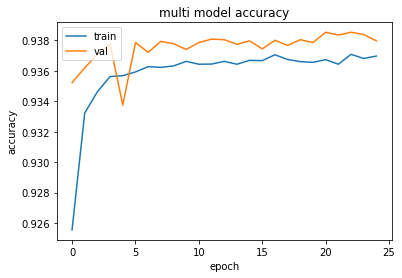

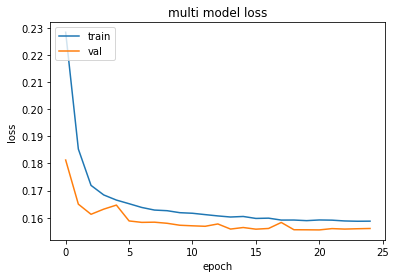

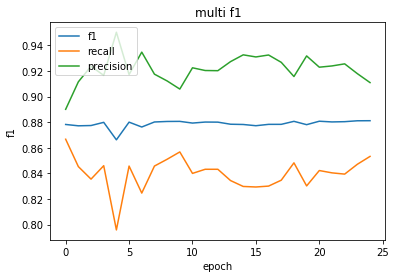

In [79]:
# summarize history for acc
plt.plot(history_multi.history['acc'])
plt.plot(history_multi.history['val_acc'])
plt.title('multi model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_multi.history['loss'])
plt.plot(history_multi.history['val_loss'])
plt.title('multi model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for f1, recall, precision
plt.plot(f1_multi.val_f1s)
plt.plot(f1_multi.val_recalls)
plt.plot(f1_multi.val_precisions)
plt.title('multi f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'recall','precision'], loc='upper left')
plt.show()

# Single Traj Model

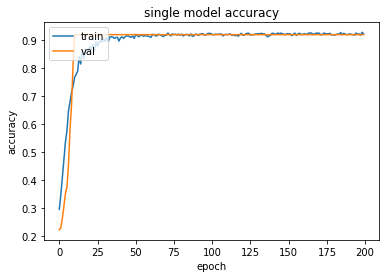

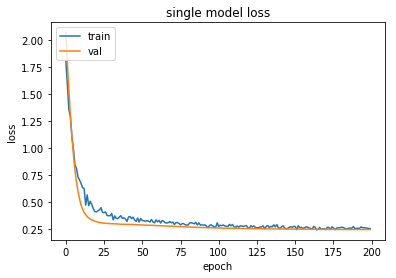

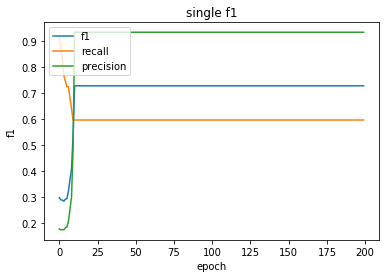

In [77]:
# summarize history for acc
plt.plot(history_single.history['acc'])
plt.plot(history_single.history['val_acc'])
plt.title('single model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_single.history['loss'])
plt.plot(history_single.history['val_loss'])
plt.title('single model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for f1, recall, precision
plt.plot(f1_single.val_f1s)
plt.plot(f1_single.val_recalls)
plt.plot(f1_single.val_precisions)
plt.title('single f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'recall','precision'], loc='upper left')
plt.show()

# Predict the Data

Predict the test_data_pred and if the p(xi) is over 0.5, save it as 1, otherwise 0. Predictions is the NumPy array saving the result. Formulate pd.DataFrame from df_testPred['trajectory_id'] and predictions ('target') so that the output DataFrame is in ['id', 'target'] format.

In [93]:
###################prediction for Multi Traj#######################
predictions = model_multi.predict(test_data)

predictions = (predictions >= 0.5) *1


id_multi = pd.DataFrame(last_traj_test['trajectory_id'])

target_multi = pd.DataFrame(predictions)
# target.columns = ['zeros','target']
# target = target['target']
target_multi.columns = ['target']

output_multi = pd.concat([id_multi.reset_index(drop=True),target_multi.reset_index(drop=True)], axis=1)
output_multi.columns = ['id', 'target']


###################prediction for Single Traj#######################
predictions = model_single.predict(one_test_data)

predictions = (predictions >= 0.5) *1


id_single = pd.DataFrame(one_traj_test['trajectory_id'])

target_single = pd.DataFrame(predictions)
# target.columns = ['zeros','target']
# target = target['target']
target_single.columns = ['target']

output_single = pd.concat([id_single.reset_index(drop=True),target_single.reset_index(drop=True)], axis=1)
output_single.columns = ['id', 'target']


####################append single and multi########################

output = output_multi.append(output_single).reset_index(drop = True)

output.to_csv("/Users/Godwithus/Desktop/EY/Hashed_4.csv", index=False)

output

,id,target
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0
5,traj_0006535be25bb52dd06983447880c964_5_12,0
6,traj_0006f84bb33ec929d1cda7686f861d0a_31_3,1
7,traj_00093ae562586aed0e053b8431e8ace4_23_10,0
8,traj_000c739e444a70e1804d757a0580caaa_31_3,1
9,traj_000d479078af08618bddc7f09082b8c3_11_6,0
